# Forecasting using spatio-temporal data with combined Graph Convolution + LSTM model

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

import os
import sys
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

import stellargraph as sg
from stellargraph.layer import GCN_LSTM

In [2]:
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

def scale_data(train_data, test_data):
    max_deaths = train_data.max()
    min_deaths = train_data.min()
    train_scaled = (train_data - min_deaths) / (max_deaths - min_deaths)
    test_scaled = (test_data - min_deaths) / (max_deaths - min_deaths)
    return train_scaled, test_scaled

def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    #14,1,
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

def rescale_data(train_scaled_data,test_scaled_data):
    train_rescaled = (train_scaled_data * (max_deaths - min_deaths)) + min_deaths
    test_rescaled = (test_scaled_data * (max_deaths - min_deaths)) + min_deaths
    return train_rescaled, test_rescaled

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def gcn_lstm(x,y):
    adj = np.matrix(y.to_numpy())

    num_nodes, time_len = state_data.shape
    print("No. of States:", num_nodes, "\nNo of timesteps:", time_len)

    train_rate = 0.9
    train_data, test_data = train_test_split(state_data, train_rate)
    print("Train data: ", train_data.shape)
    print("Test data: ", test_data.shape)

    train_scaled, test_scaled = scale_data(train_data, test_data)

    seq_len = 14
    pre_len = 1

    trainX, trainY, testX, testY = sequence_data_preparation(
        seq_len, pre_len, train_scaled, test_scaled
    )
    print(trainX.shape)
    print(trainY.shape)
    print(testX.shape)
    print(testY.shape)

    gcn_lstm = GCN_LSTM(
        seq_len=seq_len,
        adj=adj,
        gc_layer_sizes=[32, 16], #[32,16]
        gc_activations=["relu", "relu"],
        lstm_layer_sizes=[200],
        lstm_activations=["tanh"]
    )

    x_input, x_output = gcn_lstm.in_out_tensors()

    model = Model(inputs=x_input, outputs=x_output)

    opt = keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.MAPE
    model.compile(optimizer=opt, loss="mae", metrics=["mse"])
    # model.compile(optimizer="adam", loss="mae", metrics=["mse"])

    history = model.fit(
        trainX,
        trainY,
        epochs=200,
        batch_size=10,
        shuffle=True,
        verbose=0,
        validation_data=(testX, testY),
    )

    model.summary()

    print(
        "Train loss: ",
        history.history["loss"][-1],
        "\nTest loss:",
        history.history["val_loss"][-1],
    )

    sg.utils.plot_history(history)

    ythat = model.predict(trainX)
    yhat = model.predict(testX)

    ## Rescale values
    max_deaths = train_data.max()
    min_deaths = train_data.min()

    ## actual train and test values
    train_rescref = np.array((trainY * (max_deaths - min_deaths))+min_deaths)
    test_rescref = np.array((testY * (max_deaths - min_deaths))+min_deaths)

    ## Rescale model predicted values
    train_rescpred = np.array(((ythat) * (max_deaths - min_deaths))+min_deaths)
    test_rescpred = np.array(((yhat) * (max_deaths - min_deaths))+min_deaths)

    ##all test result visualization
    # time_point = 1
    # fig1 = plt.figure(figsize=(15, 8))
    # #    ax1 = fig1.add_subplot(1,1,1)
    # a_pred = test_rescpred[:, time_point]
    # a_true = test_rescref[:, time_point]
    # plt.plot(a_pred, "r-", label="prediction")
    # plt.plot(a_true, "b-", label="true")
    # plt.xlabel("time")
    # plt.ylabel("Death")
    # plt.legend(loc="best", fontsize=10)
    # plt.show()

    true_sum = []
    pred_sum = []
    for i in range(len(test_rescpred)):
        pred_sum.append(test_rescpred[i].sum())
        true_sum.append(test_rescref[i].sum())

    time_point = 1
    fig1 = plt.figure(figsize=(15, 8))
    #    ax1 = fig1.add_subplot(1,1,1)
    a_pred = pred_sum
    a_true = true_sum
    plt.plot(a_pred, "r-", label="prediction")
    plt.plot(a_true, "b-", label="true")
    plt.xlabel("time")
    plt.ylabel("Death")
    plt.legend(loc="best", fontsize=10)
    plt.savefig("predictions/"+adj_file)

    print("MAPE: "+str(mean_absolute_percentage_error(a_true,a_pred)))

ADJ : 1
No. of States: 51 
No of timesteps: 297
Train data:  (51, 267)
Test data:  (51, 30)
(253, 51, 14)
(253, 51)
(16, 51, 14)
(16, 51)


<ipython-input-3-a540205fa136>:29: ExperimentalWarning: GCN_LSTM is experimental: Lack of unit tests and code refinement (see: https://github.com/stellargraph/stellargraph/issues/1132, https://github.com/stellargraph/stellargraph/issues/1526, https://github.com/stellargraph/stellargraph/issues/1564). It may be difficult to use and may have major changes at any time.
  gcn_lstm = GCN_LSTM(


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 51, 14)]          0         
_________________________________________________________________
tf.expand_dims (TFOpLambda)  (None, 51, 14, 1)         0         
_________________________________________________________________
reshape (Reshape)            (None, 51, 14)            0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 51, 32)            3100      
_________________________________________________________________
fixed_adjacency_graph_convol (None, 51, 16)            3164      
_________________________________________________________________
reshape_1 (Reshape)          (None, 51, 16, 1)         0         
_________________________________________________________________
permute (Permute)            (None, 16, 51, 1)         0     

MAPE: 28.71019021859633
----------------------------------------------------------------------------------------------
ADJ : 5
No. of States: 51 
No of timesteps: 297
Train data:  (51, 267)
Test data:  (51, 30)
(253, 51, 14)
(253, 51)
(16, 51, 14)
(16, 51)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 51, 14)]          0         
_________________________________________________________________
tf.expand_dims_4 (TFOpLambda (None, 51, 14, 1)         0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 51, 14)            0         
_________________________________________________________________
fixed_adjacency_graph_convol (None, 51, 32)            3100      
_________________________________________________________________
fixed_adjacency_graph_convol (None, 51, 16)            3164      


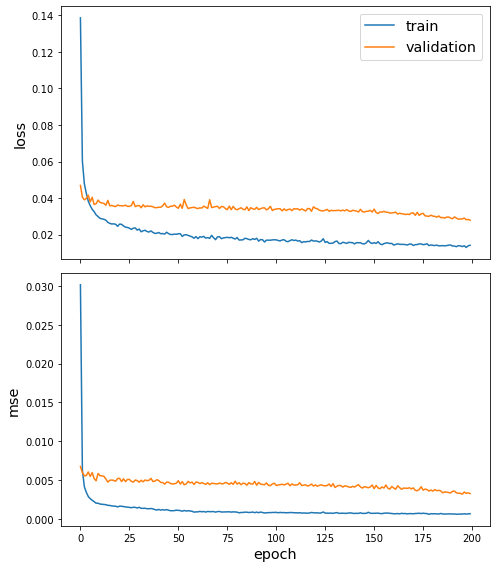

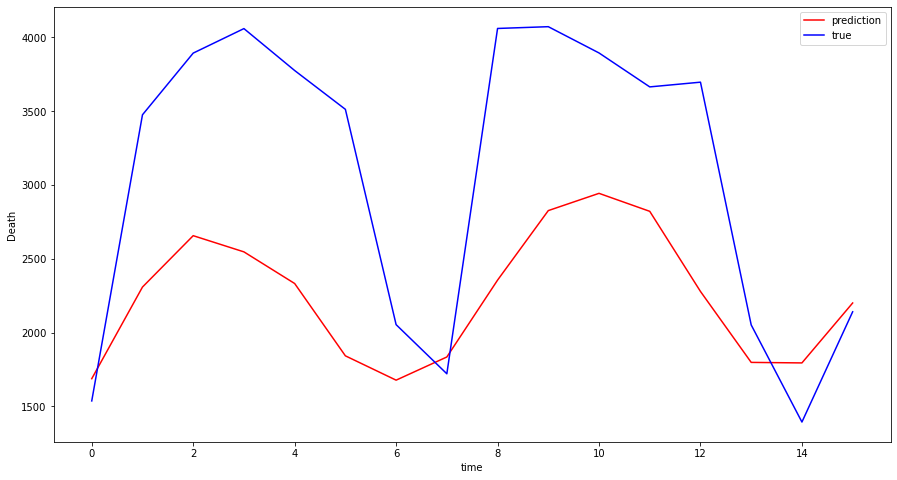

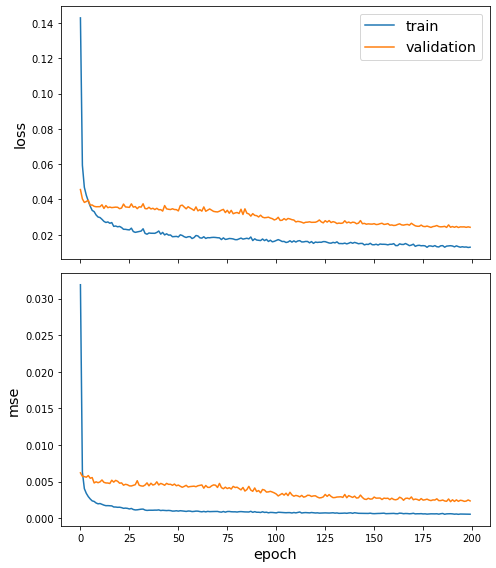

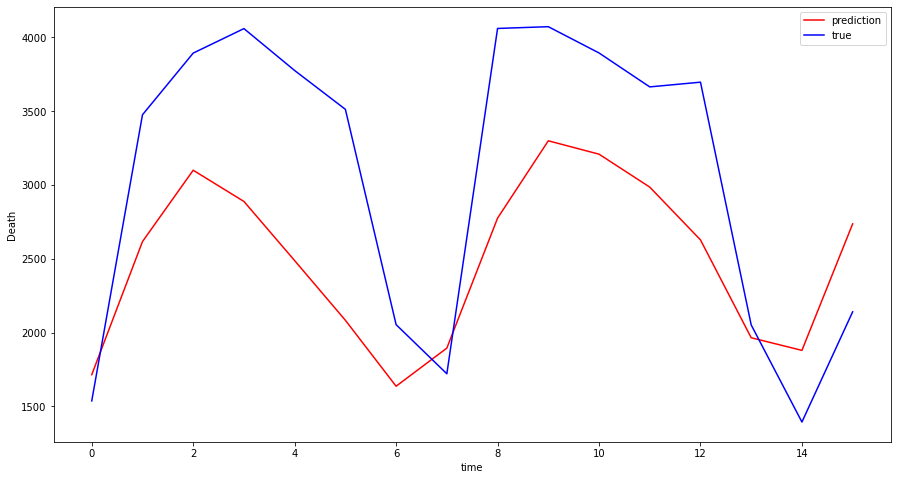

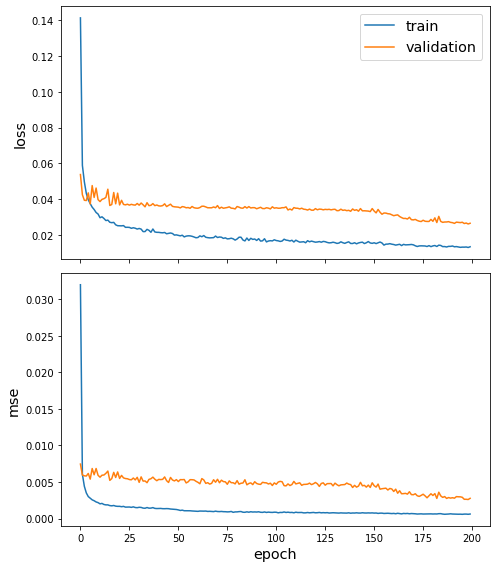

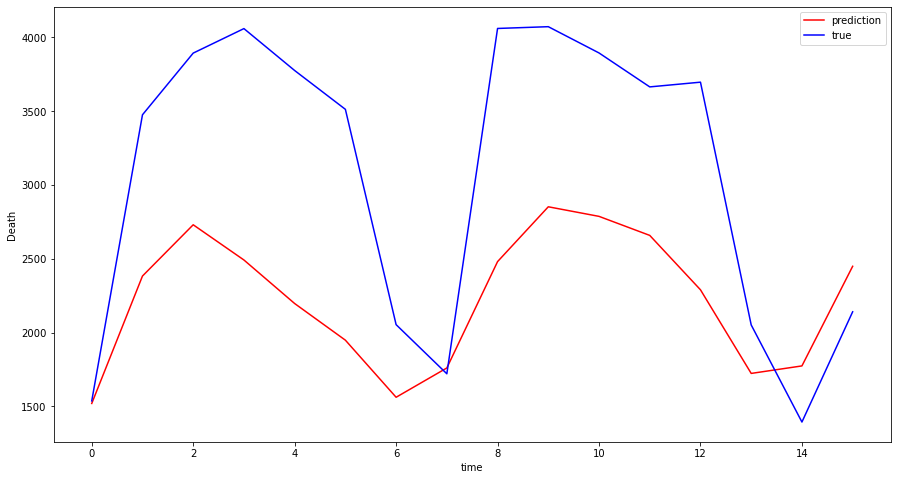

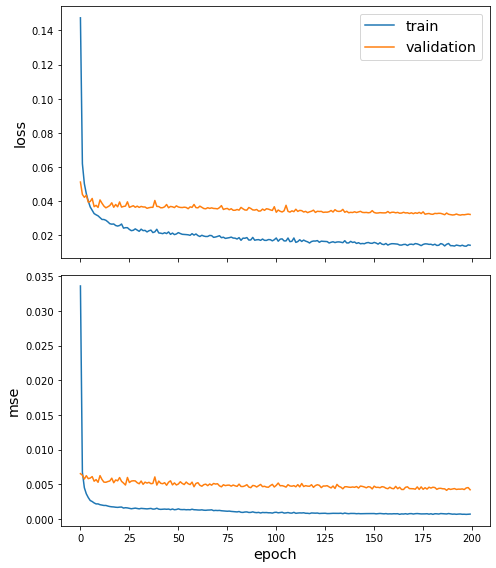

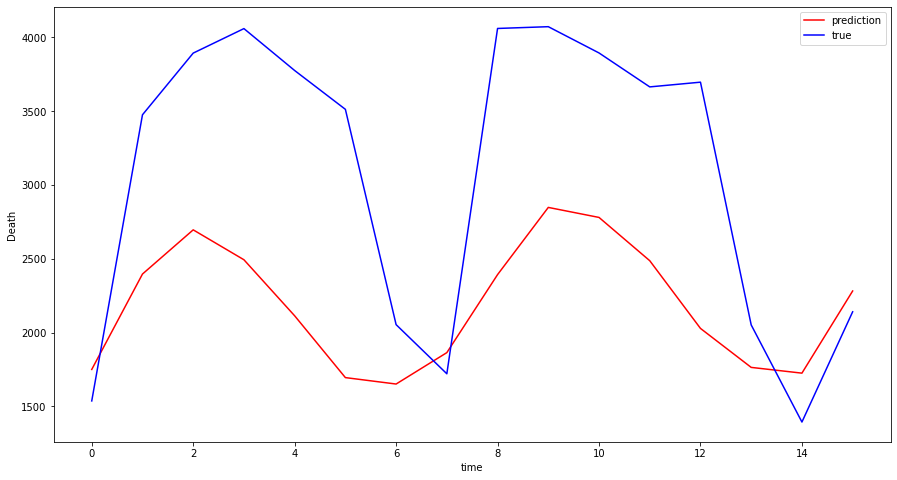

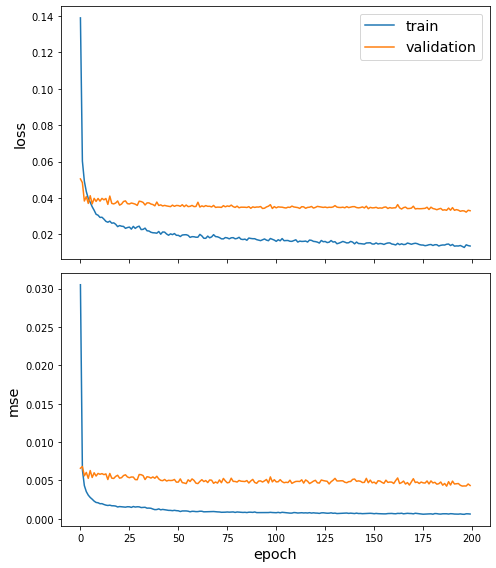

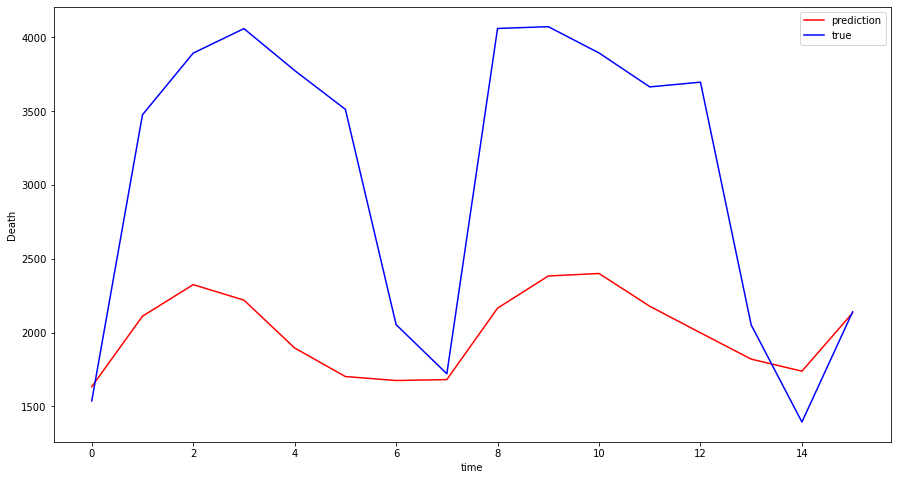

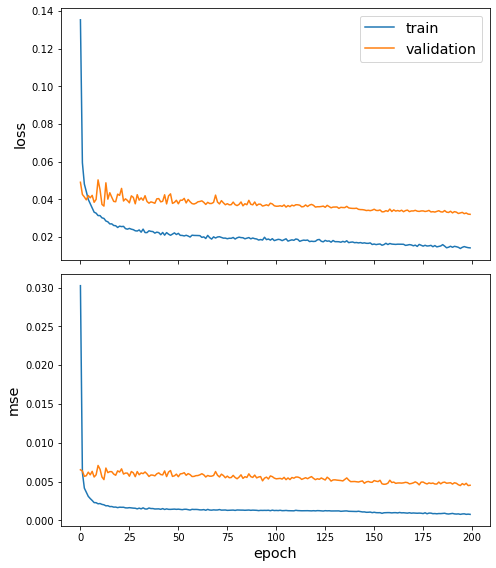

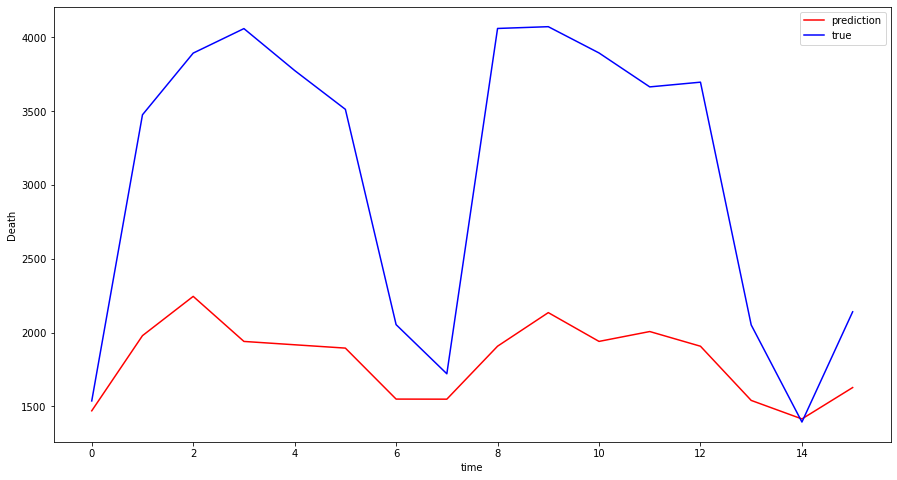

In [4]:
state_x_time = pd.read_csv("dataset/state_X_time_matrix.csv", index_col=0)
state_x_time.drop(state_x_time.columns[list(range(70))], axis = 1, inplace = True)
state_data = state_x_time.sort_index()
state_data = state_data.drop([72,73,74,75,76])
for i in range(6):
    print("ADJ : "+str(i+1))
    adj_file = "adj"+str(i+1)
    state_x_state = pd.read_csv("dataset/adj/"+adj_file+".csv", index_col=0)
    gcn_lstm(state_x_time,state_x_state)
    print("----------------------------------------------------------------------------------------------")